# تحميل (استيراد) المكتبات الأساسية
# Importing

In [1]:
# Re-import required libraries after environment reset
import os
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
from datetime import datetime
import calendar

# إدخال بيانات التواريخ
# Input dates

In [2]:
# --- User Input ---
year = 2017
month = 9
start_day = 10
end_day = 13

# العمليات علي الأيام و السنين

In [3]:
# Handle valid day range for month/year
last_day = calendar.monthrange(year, month)[1]
end_day = min(end_day, last_day)

# Format date strings for URL
year_str = f"{year}"
month_str = f"{month:02d}"
start_str = f"{year}{month_str}01"
end_str = f"{year}{month_str}{last_day:02d}"

#  فحص الأقمار الصناعية GOSE
# و عرض المتاح منها

🔍 Trying GOES-01...
❌ GOES-01 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-02...
❌ GOES-02 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-03...
❌ GOES-03 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-04...
❌ GOES-04 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-05...
❌ GOES-05 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-06...
❌ GOES-06 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-07...
❌ GOES-07 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-08...
❌ GOES-08 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-09...
❌ GOES-09 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-10...
❌ GOES-10 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-11...
❌ GOES-11 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-12...
❌ GOES-12 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-13...
✅ Data found for GOE

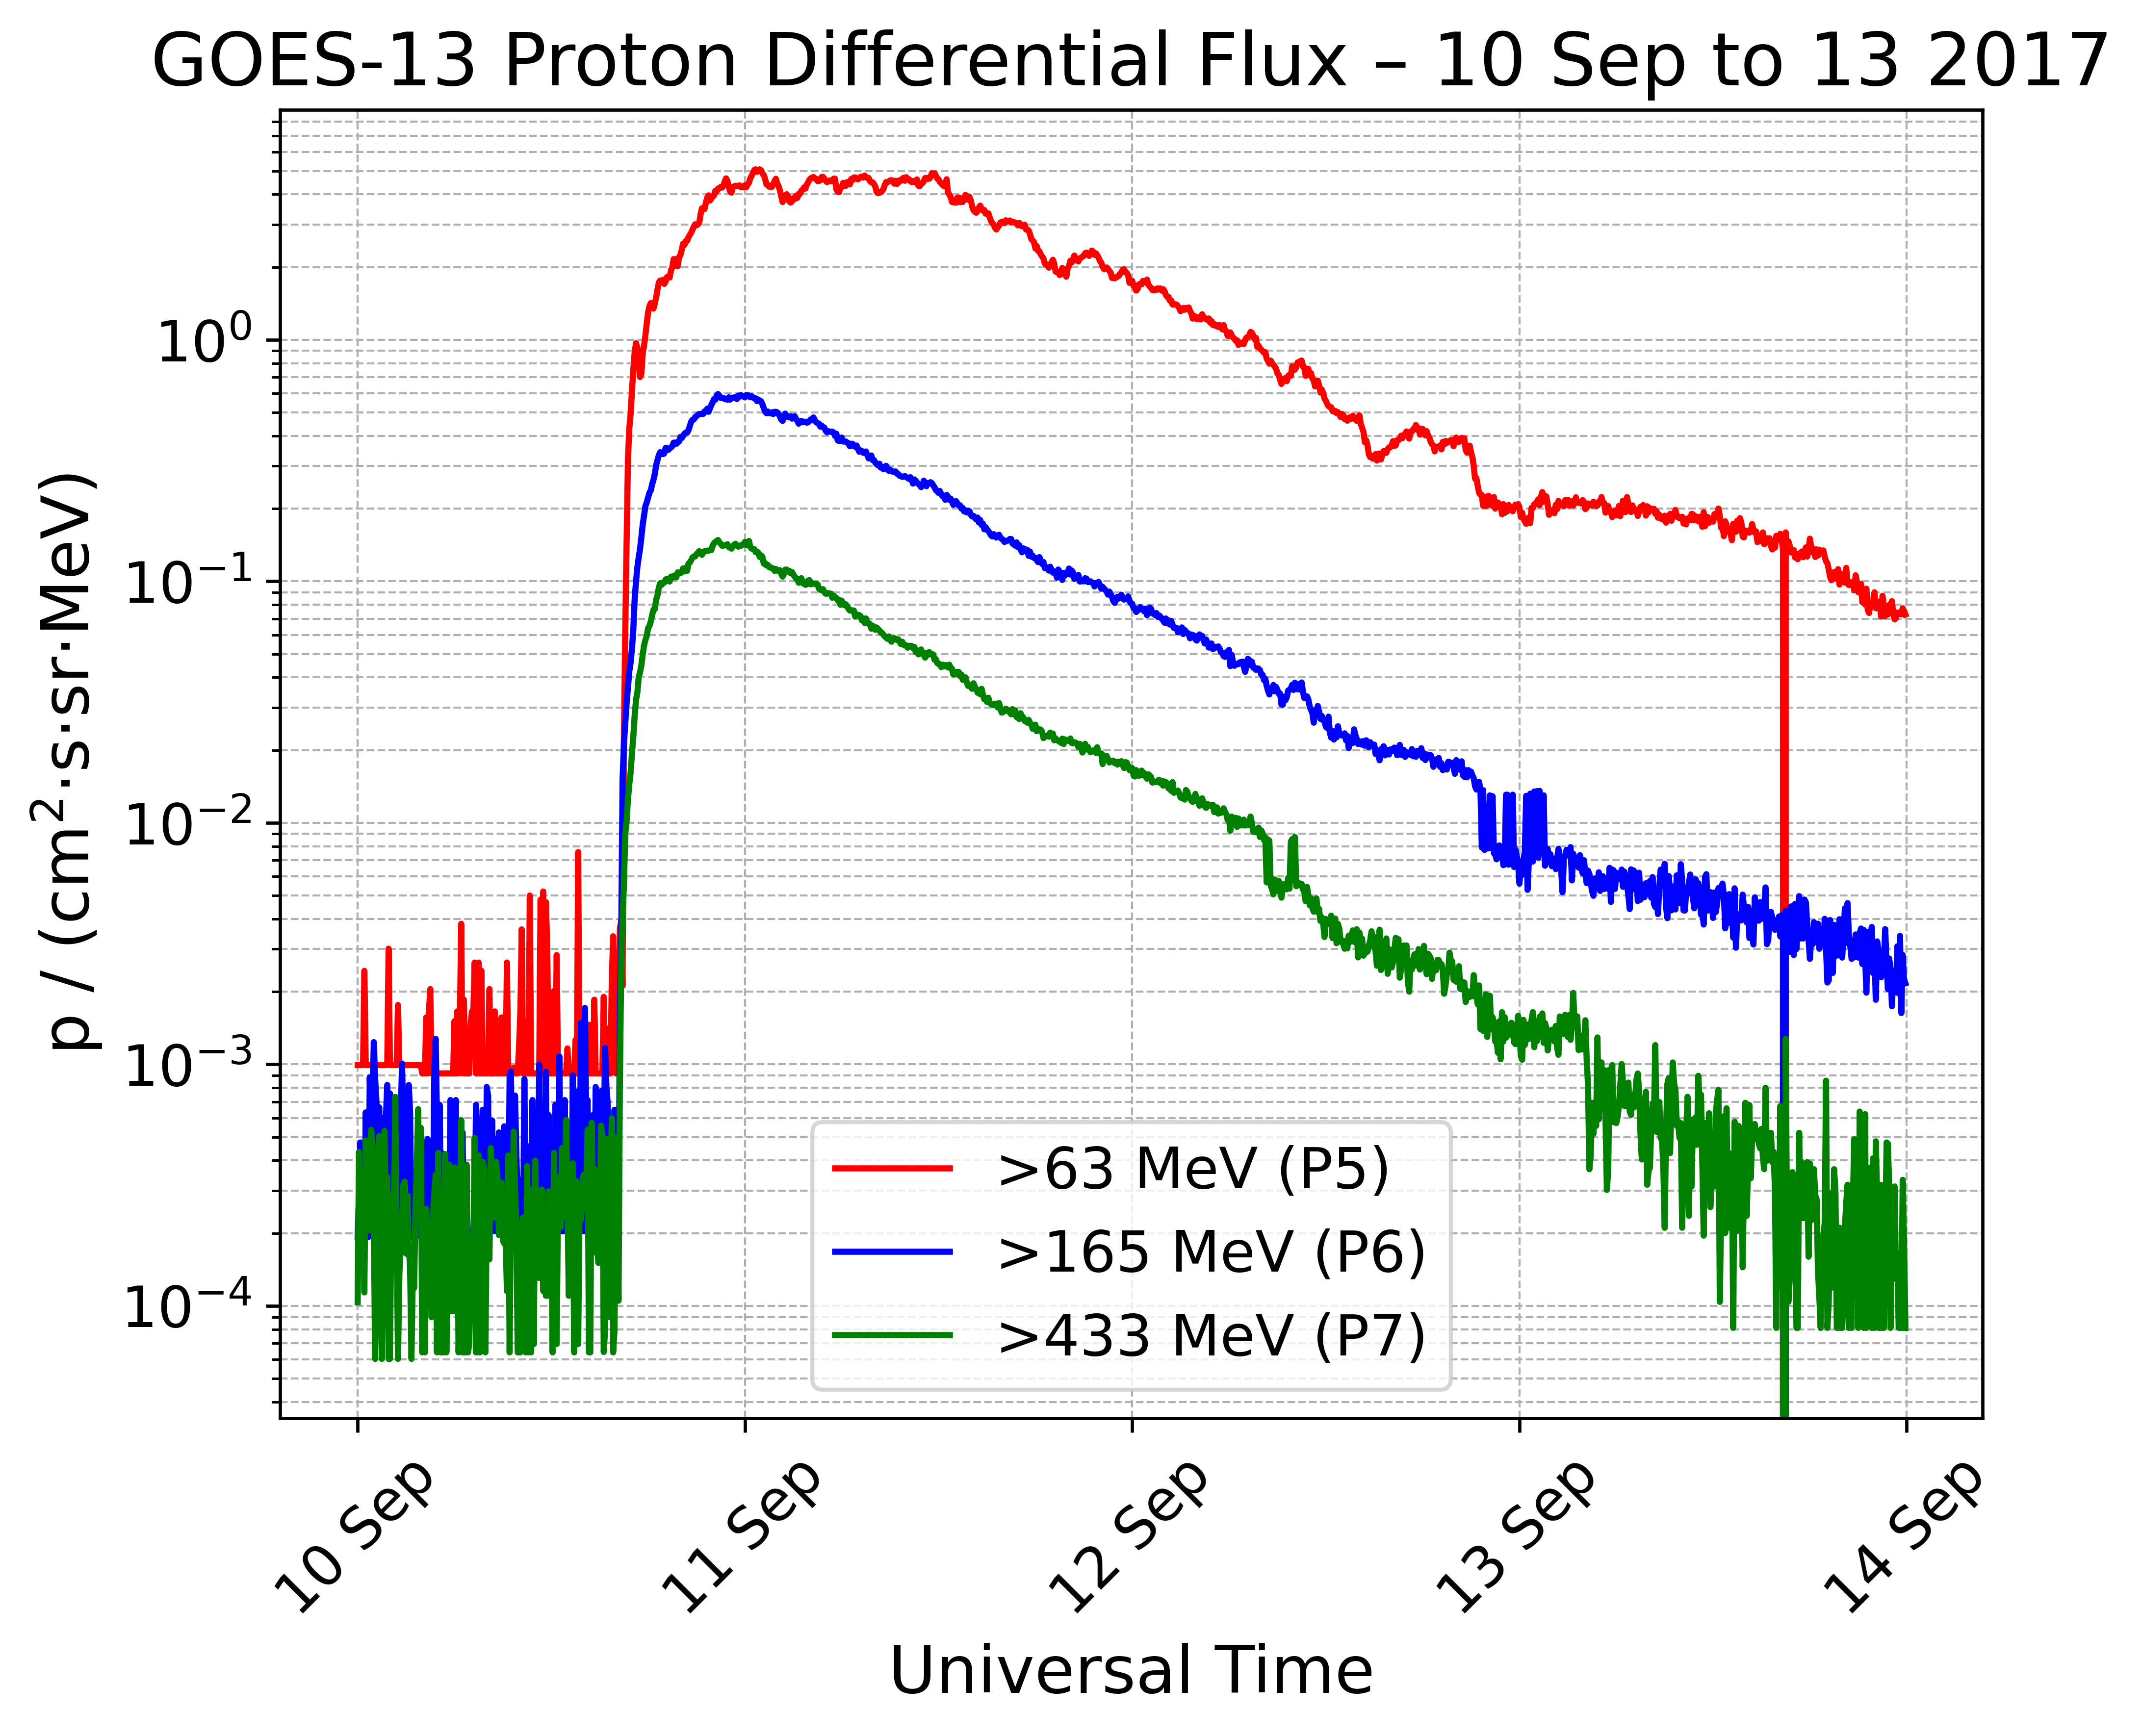

🔍 Trying GOES-14...
❌ GOES-14 not available or error: HTTP Error 404: Not Found
🔍 Trying GOES-15...
✅ Data found for GOES-15


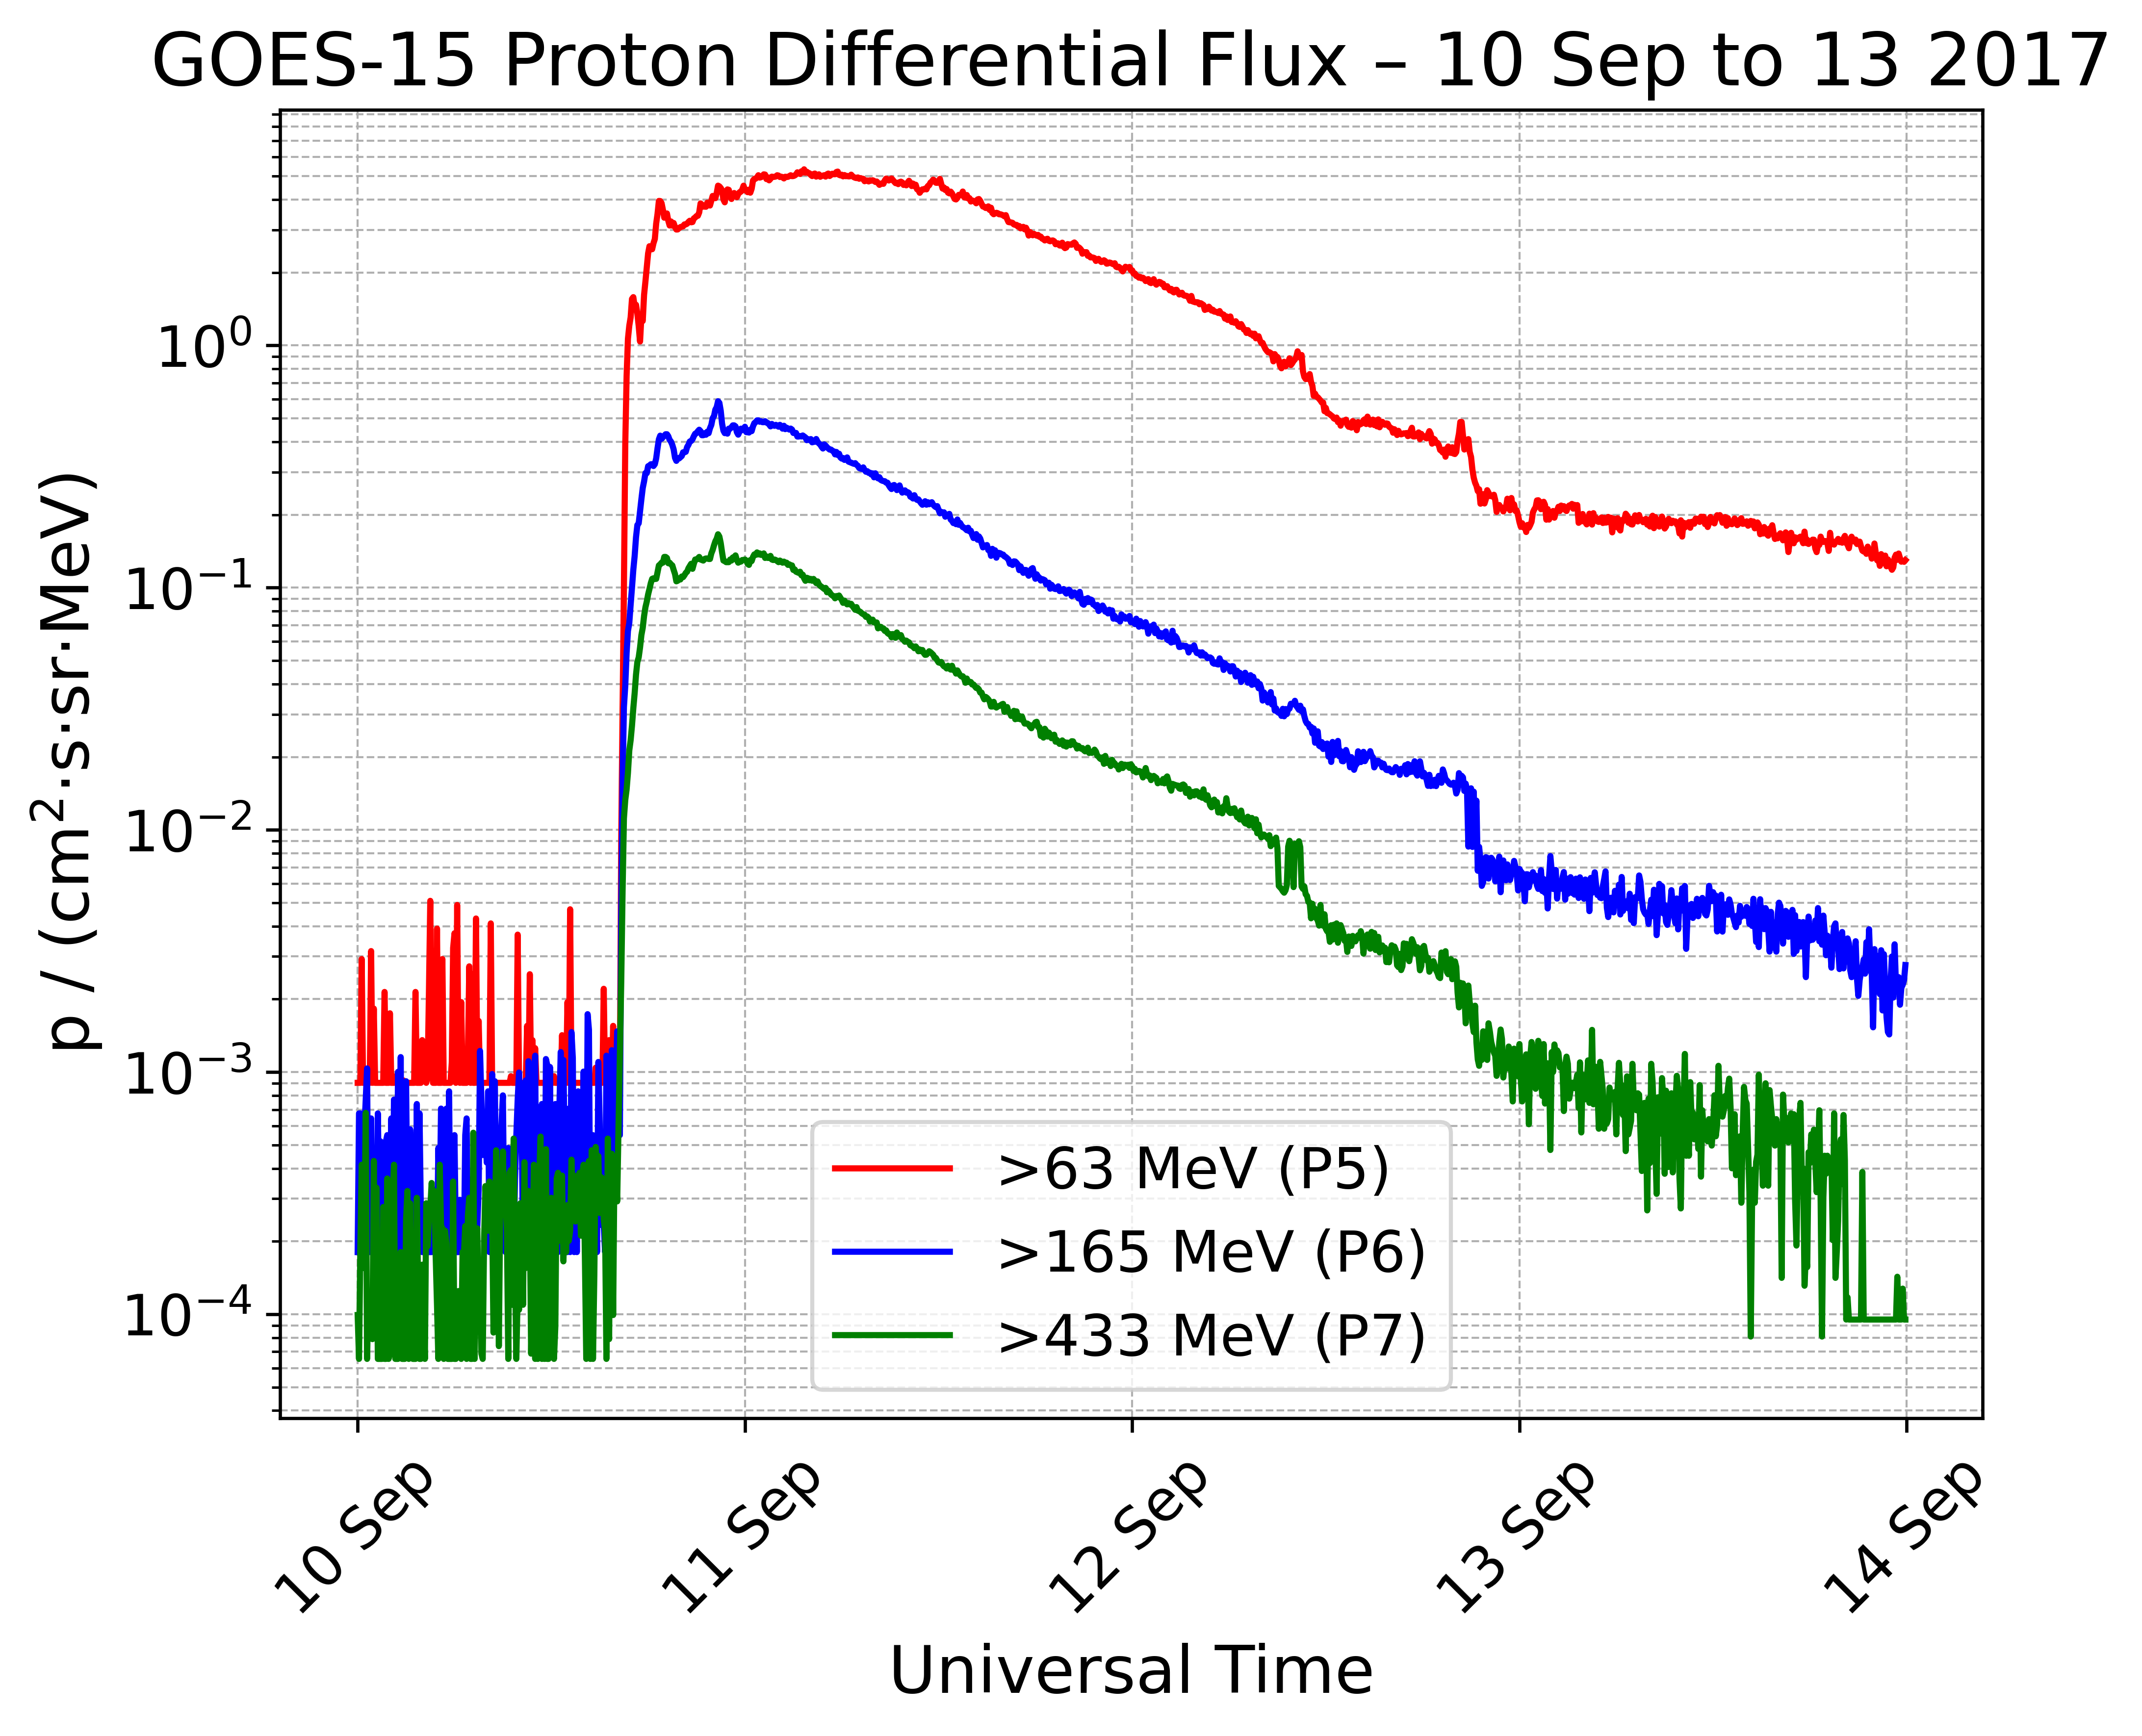

[('13',
  {'P5W_COR_FLUX': 'p/(cm^2 s sr MeV)',
   'P6W_COR_FLUX': 'p/(cm^2 s sr MeV)',
   'P7W_COR_FLUX': 'p/(cm^2 s sr MeV)'}),
 ('15',
  {'P5W_COR_FLUX': 'p/(cm^2 s sr MeV)',
   'P6W_COR_FLUX': 'p/(cm^2 s sr MeV)',
   'P7W_COR_FLUX': 'p/(cm^2 s sr MeV)'})]

In [4]:
# --- Loop through GOES satellites 01 to 15 ---
satellite_logs = []

for sat in range(1, 16):
    sat_str = f"{sat:02d}"
    url = (
        f"https://www.ncei.noaa.gov/data/goes-space-environment-monitor/access/"
        f"avg/{year_str}/{month_str}/goes{sat_str}/netcdf/"
        f"g{sat_str}_epead_p17ew_5m_{start_str}_{end_str}.nc"
    )
    local_path = f"/tmp/g{sat_str}_epead_sep.nc"

    try:
        print(f"🔍 Trying GOES-{sat_str}...")
        urllib.request.urlretrieve(url, local_path)
        print(f"✅ Data found for GOES-{sat_str}")

        # --- Load and extract data ---
        ds = xr.open_dataset(local_path)

        # Log flux variable units
        unit_info = {}
        for var in ['P5W_COR_FLUX', 'P6W_COR_FLUX', 'P7W_COR_FLUX']:
            unit_info[var] = ds[var].attrs.get('units', 'N/A')
        satellite_logs.append((sat_str, unit_info))

        time = pd.to_datetime(ds['time_tag'].values)
        df = pd.DataFrame({
            'Time': time,
            '>63 MeV (P5)': ds['P5W_COR_FLUX'].values,
            '>165 MeV (P6)': ds['P6W_COR_FLUX'].values,
            '>433 MeV (P7)': ds['P7W_COR_FLUX'].values
        })

        # Filter by date
        start_date = datetime(year, month, start_day)
        end_date_dt = datetime(year, month, end_day + 1)
        df_sep = df[(df['Time'] >= start_date) & (df['Time'] < end_date_dt)]

        # --- Plot ---
        plt.figure(figsize=(7, 6), dpi = 600)
        plt.semilogy(df_sep['Time'], df_sep['>63 MeV (P5)'], label='>63 MeV (P5)', color='red')
        plt.semilogy(df_sep['Time'], df_sep['>165 MeV (P6)'], label='>165 MeV (P6)', color='blue')
        plt.semilogy(df_sep['Time'], df_sep['>433 MeV (P7)'], label='>433 MeV (P7)', color='green')

        plt.title(f"GOES-{sat_str} Proton Differential Flux – {start_date:%d %b} to {end_day} {year}", fontsize=18)
        plt.xlabel("Universal Time", fontsize=16)
        plt.ylabel("p / (cm$^{2}$·s·sr·MeV)", fontsize=16)
        plt.legend(fontsize=14)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)

        ax = plt.gca()
        ax.xaxis.set_major_locator(mdates.DayLocator())  # one tick per day
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))  # e.g., 10 Sep



        plt.xticks(rotation=45, fontsize=14)
        plt.yticks(fontsize=14)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ GOES-{sat_str} not available or error: {str(e)}")
        continue

# Display important info summary
satellite_logs
